# Image Classification

### Importing Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import operator
import os

import matplotlib.pyplot as plt
from sklearn import preprocessing 

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from collections import Counter
from sklearn.metrics import confusion_matrix,classification_report, f1_score

import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

from imblearn.over_sampling import SMOTE



Using plaidml.keras.backend backend.


### Reading training data, labels and Test data

In [2]:
# Importing Training Data

train_data = pd.read_table('/Users/fanusarefaine/Desktop/data/train.dat', delimiter=' ', header=None)
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,877,878,879,880,881,882,883,884,885,886
0,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.002525,0.001105,0.018071,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078
1,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.001026,0.000000,0.018462,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078
2,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.011023,0.006921,0.053320,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078
3,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.000000,0.000919,0.030331,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078
4,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.003866,0.001074,0.025558,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078


In [3]:
# Importing Training Labels

train_labels = pd.read_csv('/Users/fanusarefaine/Desktop/data/train.labels', sep='\n', header=None, skiprows = 0)
train_labels.head()

,0
0,2
1,1
2,1
3,1
4,2


In [4]:
# Importing the test data

test_data = pd.read_csv('/Users/fanusarefaine/Desktop/data/test.dat', sep=' ', header=None, skiprows = 0)
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,877,878,879,880,881,882,883,884,885,886
0,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.003325,0.001961,0.022592,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078
1,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.002079,0.002495,0.019543,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078
2,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.004835,0.002149,0.027934,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078
3,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.011478,0.006456,0.043042,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078
4,10.177829,10.177829,10.177829,5.765479,10.177829,10.177829,4.982583,7.986466,0.480342,2.385175,...,0.002801,0.001528,0.015279,0.043203,0.202189,0.304724,0.630184,0.548963,0.638825,0.599078


In [6]:
# Checking how many data records each label refers to 

# The output shows clear data imbalance

train_labels[0].value_counts()

1     8841
2     6506
3     1467
8      704
4      249
5      168
7       45
6       12
11       6
10       2
Name: 0, dtype: int64

In [7]:
# Converting the labels from dataframe objects to list object

labels = train_labels.values.flatten().tolist()
len(labels)

18000

##  Feature Selection

     * Removing features with a zero standard deviaion and those values that does not change
     
     * Since their values do not change - they do not have much contribution to our classification algorithm
   

In [8]:
# Removing features with almost zero standard deviation - having values that does not change 

print("Original data shape- ", train_data.shape)

# Remove Constant Features
constant_features = [feat for feat in train_data.columns if (train_data[feat].std() == 0 or train_data[feat].min()==train_data[feat].max())]

# Dropping all the data with constant values 
train_data.drop(labels=constant_features, axis=1, inplace=True)
test_data.drop(labels=constant_features, axis=1, inplace=True)

print("Reduced feature train dataset shape-",train_data.shape)
print("Reduced feature test dataset shape- ", test_data.shape)

Original data shape-  (18000, 887)
Reduced feature train dataset shape- (18000, 48)
Reduced feature test dataset shape-  (3000, 48)


In [10]:
# Looking into the max values of the data to examine proportionality difference

# As we can see below, the data does not have much proportionality difference

# Since the data does not have much proportional difference, normalization or scaling is not required

train_data.max()

832    0.496170
833    0.674745
834    0.426787
835    1.000000
836    0.712500
837    0.589065
838    0.277056
839    0.658063
840    0.501943
841    0.627143
842    0.451737
843    1.000000
844    0.708333
845    0.613426
846    0.284271
847    0.657291
848    0.438462
849    0.590561
850    0.460131
851    1.000000
852    0.707738
853    0.614706
854    0.284271
855    0.659383
856    0.438462
857    0.590561
858    0.460131
859    1.000000
860    0.707738
861    0.614706
862    0.284271
863    0.659383
864    1.000000
865    0.233333
866    0.184783
867    0.198519
868    0.285714
869    0.051429
870    0.047917
871    0.047619
872    1.000000
873    0.528571
874    0.381364
875    0.241079
876    0.173333
877    0.151389
878    0.157787
879    0.180824
dtype: float64

## Handling Imbalanced Data

In [23]:
# I am using Synthetic Minority Overasampling Technique (SMOTE) to handle the data imbalance in the dataset
sm = SMOTE({5:4000, 11:4000, 10:4000, 6:4000, 7:4000, 4:8000, 8:4000, 3:4000}, random_state=42, k_neighbors = 1)

In [24]:
# Fitting the training dataset and labels 
bal_train_data, bal_labels = sm.fit_sample(train_data, labels)

In [25]:
# Checking the dataset after the synthetic samples to the dataset
Counter(bal_labels)

Counter({2: 6506,
         1: 8841,
         3: 4000,
         8: 4000,
         4: 8000,
         5: 4000,
         7: 4000,
         6: 4000,
         11: 4000,
         10: 4000})

## Split Data Into Training and Testing Subsets

In [28]:
# split into training and testing datasets

# Split proportion of 80% training and 20% testing subsets

X_train, X_test, y_train, y_test = train_test_split(bal_train_data, bal_labels, test_size = 0.20, random_state = 42)

## Building Classification Algorithms

In [30]:
# Function to print the results for the every combination of the GridSearchCV

def print_results(results):
    print("Best Params: {}\n".format(results.best_params_))   
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean,3), round(std*2, 3), params))

## Support Vector Machines

In [32]:
# Support vector machine to classifiy the classes of images

svc = SVC()

# Hyperparameters of SVM
parameters = { 'kernel': ['linear','rbf'], 'C': [0.01, 0.1]}

# Using GridSearchCV to see performance of the model with different combinations of hyperparameters
cv = GridSearchCV(svc, parameters, cv=5)

# Fitting the training data and respective labels
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1], 'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [33]:
# Printing the results using the function above
print_results(cv)

Best Params: {'C': 0.1, 'kernel': 'rbf'}

0.461 (+/-0.01) for {'C': 0.01, 'kernel': 'linear'}
0.492 (+/-0.006) for {'C': 0.01, 'kernel': 'rbf'}
0.538 (+/-0.005) for {'C': 0.1, 'kernel': 'linear'}
0.567 (+/-0.01) for {'C': 0.1, 'kernel': 'rbf'}


In [34]:
# Prediction using the SVM model
test_pred = cv.predict(X_test)

In [35]:
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))

Accuracy score for Testing Dataset =  0.5788704965920156


In [36]:
print('Accuracy score for Testing Dataset = ', f1_score(y_test, test_pred, average='macro'))

Accuracy score for Testing Dataset =  0.5405631484299442


         As we can see in the above classification using SVM, the result is not satisfactory.

## Ensemble Methods

In [50]:
# Using ensemble classifiers 

ensemble_voting = VotingClassifier([ 
    ('et', OneVsRestClassifier(ExtraTreesClassifier(n_estimators = 1000))),
    ('randomforest', RandomForestClassifier(n_estimators=1000)),
    ('knn', OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 1000))),
    ('ada', AdaBoostClassifier(learning_rate=0.1, n_estimators=1000)),
    ('xgboost', XGBClassifier(learning_rate =0.1, n_estimators=1000, num_class = 11))], voting='soft',weights=[1,2,2,1,1])

In [51]:
# Fitting training dataset and labels 

ensemble_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('et',
                              OneVsRestClassifier(estimator=ExtraTreesClassifier(bootstrap=False,
                                                                                 ccp_alpha=0.0,
                                                                                 class_weight=None,
                                                                                 criterion='gini',
                                                                                 max_depth=None,
                                                                                 max_features='auto',
                                                                                 max_leaf_nodes=None,
                                                                                 max_samples=None,
                                                                                 min_impurity_decrease=0.0,
                                                               

In [85]:
# Prediction using the ensemble classifiers
test_pred = ensemble_voting.predict(X_test)

In [53]:
# Computing the accuracy of the model
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))


Accuracy score for Testing Dataset =  0.9149951314508277


In [82]:
# Computing the F1 Score

from sklearn.metrics import accuracy_score, f1_score
print('Accuracy score for Testing Dataset = ', f1_score(y_test, test_pred, average='macro'))

Accuracy score for Testing Dataset =  0.9337615883291022


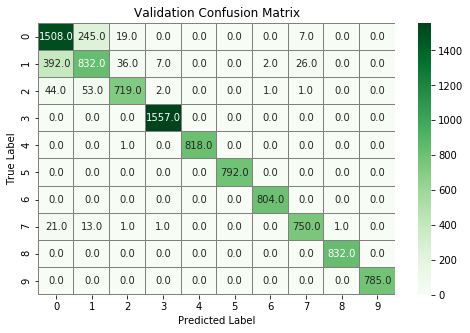

In [83]:
# SInce Ensemble Classifiers' Classification perfmance is very good, Here I provide several evaluation techniques
import seaborn as sns

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, test_pred) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

In [86]:
test_pred = test_pred.tolist()

In [87]:
# Printing the classification report for the ensemble classifier to monitor performance in each class

print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           1       0.85      0.77      0.81      1965
           2       0.64      0.73      0.68      1143
           3       0.88      0.93      0.90       776
           4       1.00      0.99      1.00      1567
           5       1.00      1.00      1.00       818
           6       1.00      1.00      1.00       792
           7       1.00      1.00      1.00       807
           8       0.95      0.96      0.95       784
          10       1.00      1.00      1.00       833
          11       1.00      1.00      1.00       785

    accuracy                           0.91     10270
   macro avg       0.93      0.94      0.93     10270
weighted avg       0.92      0.91      0.92     10270



In [78]:
ImageID = np.arange(1,len(prediction)+1)
ImageID

array([   1,    2,    3, ..., 2998, 2999, 3000])

In [80]:
# Saving the model to the disc for later use

output_df = pd.DataFrame({'ImageID': ImageID, 'Class': prediction})
output_df.to_csv('/Users/fanusarefaine/Desktop/output_ensemble.dat', index=False)

    ** As we can see in the above analysis, the Ensemble Classifiers has very good performace

## Logistic Regression Classifier

In [208]:
# Logistic regression 
log_reg = LogisticRegression()

# Parameters of logistic regression
parameters = {'C': [0.001, 0.1, 1, 10, 100]}

In [209]:
# Using GridSearchCV to see the performance of logistic regression

cv = GridSearchCV(log_reg, parameters, cv=5)
cv.fit(X_train, y_train)
print_results(cv)

Best Params: {'C': 100}

0.287 (+/-0.0) for {'C': 0.001}
0.525 (+/-0.009) for {'C': 0.1}
0.589 (+/-0.007) for {'C': 1}
0.603 (+/-0.008) for {'C': 10}
0.603 (+/-0.006) for {'C': 100}


In [210]:
# Prediction
test_pred = cv.predict(X_test)

In [211]:
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))

Accuracy score for Testing Dataset =  0.5995456758072367


In [214]:
print('Accuracy score for Testing Dataset = ', f1_score(y_test, test_pred, average='macro'))

Accuracy score for Testing Dataset =  0.5762632172441253


    ** As we can see in the above, logistic regression has very poor performance in out data

## Multi-Layer Perception Classifier

In [18]:
# Multilayer Perceptron Classifier

mlp = MLPClassifier()

# Parameters of Multilayer classifier
parameters = { 'hidden_layer_sizes': [(50,), (100,)],
                'activation': ['tanh', 'relu'],
                 'learning_rate': ['adaptive', 'invscaling']}

# Monitoring the performance of the model using GridSearchCV on different combinations of paramenters
cv = GridSearchCV(mlp, parameters, cv=5, scoring='f1_micro')
cv.fit(X_train, y_train,)
print_results(cv)  

Best Params: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}

0.676 (+/-0.009) for {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.677 (+/-0.006) for {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.679 (+/-0.009) for {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}
0.682 (+/-0.013) for {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
0.687 (+/-0.019) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.688 (+/-0.01) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.713 (+/-0.004) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}
0.715 (+/-0.012) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}


In [19]:
# Prediction
test_pred = cv.predict(X_test)

In [20]:
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))

Accuracy score for Testing Dataset =  0.7252858958068615


In [21]:
print('Accuracy score for Testing Dataset = ', f1_score(y_test, test_pred, average='macro'))

Accuracy score for Testing Dataset =  0.7512039694150112


     I have provided proper cross validation for our multilayer perception classifier
     
     However, the performace of MLPClassifier on our data is not satisfactory

## Conclusion

      In the above analysis, we have seen the performance of several algorithms on our dataset. 
      
      It obviously can be observed that they have difference performaces
      
      While Ensemble classifier has the best performance, SVM classifier has fairly good performance